# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [3]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [4]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.4044690379054401
RMSE when predicting testing data:
1.0666204347667476
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [5]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [6]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851467026495314


In [7]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289873, -1.09373797, -1.0851467 ])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [8]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

### Graph summary

The graph demonstrates the changes in the root mean squared error (RMSE) as more training data is introduced. Specifically, there is a clear downward trend: the error drops first, and then it gradually levels off while maintaining the established trend, which should be expected based on the assumption that more data helps with lowering the RMSE. As a result, the model improves with more data, but the pace of the improvement is consistently slowing down, with some slight corrections (for example, around 11 and 12) where the error briefly increases.

In [9]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

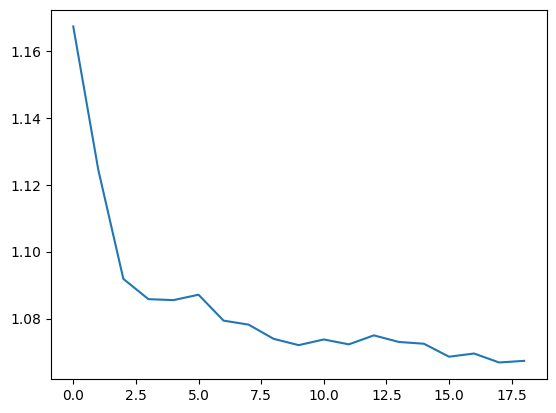

In [10]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [11]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

### Alpha = 0 vs. Alpha = 10 Prediction (Answer to Question)

The prediction results for alpha = 0 and alpha = 10 differ dramatically: the correlation jumps from -0.0186 to 0.9927. The negative correlation for alpha = 0 shows that there is no relationship between the 10 stocks and the 11th. On the other hand, the correlation for alpha = 10 approaching 1 shows a strong linear relationship between the inputs and the target. This means the model can easily learn and generalize the pattern when alpha = 10 is used.

In [12]:
from sklearn.model_selection import train_test_split

# Given code
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

# Alpha prediction
def alpha_prediction(alpha_value):
    X, y = make_X_y(alpha=alpha_value)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    correlation = np.corrcoef(y_test, y_pred)[0, 1]
    
    print(f"Results for alpha = {alpha_value}")
    print(f"Correlation: {correlation:.4f}")
    print("")

# Test for alpha_value=0 and for alpha_value=10
alpha_prediction(alpha_value=0)
alpha_prediction(alpha_value=10)   

Results for alpha = 0
Correlation: 0.0438

Results for alpha = 10
Correlation: 0.9931



### Randomized Search

Based on the results, the best-performing model was a Random Forest with 100 trees and no depth limit (max_depth=None) an a root mean squared error (RMSE) of approximately 1.2171. This configuration performs better than other model variations, especially the one with only 10 trees and the max_depth of 2, which allows us to conclude that deeper trees and more estimators improve prediction accuracy.

In [13]:
# Set random seed
np.random.seed(0)

# Generate data with selected alpha = 10
X, y = make_X_y(alpha=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GridSearchCV
gcv = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]},
    scoring="neg_root_mean_squared_error"
)

# Fit the model
gcv.fit(X_train, y_train)

# Output results
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

# List all test scores
print(gcv.cv_results_["mean_test_score"])

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.2171012713223663
[-3.25165602 -3.221524   -3.23162556 -1.38238805 -1.3411916  -1.33916435
 -1.27090679 -1.22658362 -1.21710127]


### Scoring

For this task, the r2_score was chosen from scikit-learn’s documentation (https://scikit-learn.org/dev/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score) because it provides interpretable results - the best possible score is 1.0. The r2_score function computes the coefficient of determination, which is a statistical measurement examines how differences in one variable can be explained by the difference in a second variable (the target y) when predicting the outcome of a given event (https://www.investopedia.com/terms/c/coefficient-of-determination.asp).

Applied to the Random Forest tested earlier, r2_score showed a best score of 0.9849, an impressive output that confirms the prior findings. What is interesting about using r2_score is that it makes the other model variations easier to interpret. For instance, when using the Random Forest's RMSE, the scores ranged from -3.2516 to -1.2171, which seems like a big difference. But with r2_score, it is clear that even the worst-performing model (-3.25165602) has a r2_score of 0.8893, which is not that far away from the best-performing model with a r2_score of 0.9849. Thus, the spread in model quality is not as dramatic as the RMSE made it seem because most models actually performed quite well.


In [14]:
gcv = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]},
    scoring="r2"
)

gcv.fit(X_train, y_train)

print(gcv.best_estimator_)
print(gcv.best_params_)
print("Best r2_score:", gcv.best_score_)
print("All r2_scores:", gcv.cv_results_["mean_test_score"])


RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
Best r2_score: 0.98497574658887
All r2_scores: [0.88932537 0.89361013 0.89454002 0.98102333 0.98158082 0.98192545
 0.98381512 0.98472995 0.98497575]


# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

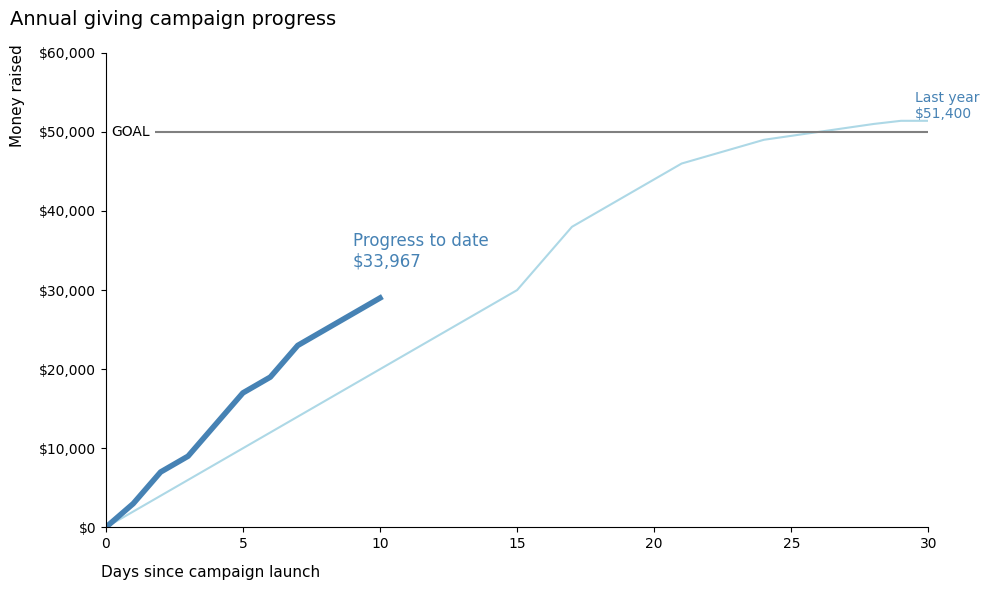

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Days and donations
days = np.arange(0, 31)
last_year = np.array([
    0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000,
    20000, 22000, 24000, 26000, 28000, 30000, 34000, 38000, 40000,
    42000, 44000, 46000, 47000, 48000, 49000, 49500, 50000, 50500,
    51000, 51400, 51400
])

current_progress = np.array([
    0, 3000, 7000, 9000, 13000, 17000, 19000, 23000, 25000, 27000,
    29000, 31000, 32000, 32500, 33000, 33967
])
days_current = np.arange(len(current_progress))

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(days, last_year, color='lightblue', linewidth=1.5)
ax.plot(days_current[:11], current_progress[:11], color='steelblue', linewidth=4)
ax.hlines(y=50000, xmin=1.8, xmax=30, color='gray', linewidth=1.5)
ax.text(29.5, 51400, 'Last year\n$51,400', color='steelblue', va='bottom')
ax.text(1.6, 50000, 'GOAL', va='center', ha='right')

# Add current progress
#ax.scatter([10], [33967], color='steelblue')
ax.text(9, 33000, 'Progress to date\n$33,967', fontsize=12, color='steelblue')

# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels
ax.set_title("Annual giving campaign progress", ha='right', x=0.28, pad=20, fontsize=14)
ax.set_xlabel("Days since campaign launch", ha='right', x=0.26, labelpad=10, fontsize=11)
ax.set_ylabel("Money raised", y=0.91, labelpad=10, fontsize=11)
ax.set_xticks(np.arange(0, 31, 5))
ax.set_yticks(np.arange(0, 65000, 10000))
ax.set_xlim(0, 30)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.set_ylim(0, 60000)
ax.grid(False)
plt.tight_layout()
plt.show()